In [1]:
#### -- 1-1. 모듈 불러오기 -- ####
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
# from torch.autograd import Variable

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
#### -- 1-2. 분석 환경 설정 -- ####
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print ('Current cuda device is', device)

Current cuda device is cuda


In [3]:
#### -- 1-3. Hyper-parameter 지정 -- ####
batch_size = 50
learning_rate = 0.0001
epoch_num = 15

In [4]:
#### -- 2-1. MNIST 데이터 불러오기 -- ####
train_data = datasets.MNIST(root = './data', train = True, download = True, transform = transforms.ToTensor())
test_data = datasets.MNIST(root = './data', train = False, transform = transforms.ToTensor())

print('number of training data: ', len(train_data))
print('number of test data: ', len(test_data))

# Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to data\MNIST\raw\train-images-idx3-ubyte.gz
# 9920512it [00:01, 5592512.82it/s]                                                                                      
# Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw
# Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to data\MNIST\raw\train-labels-idx1-ubyte.gz
# 32768it [00:00, 66241.35it/s]                                                                                          
# Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw
# Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to data\MNIST\raw\t10k-images-idx3-ubyte.gz
# 1654784it [00:01, 1214690.45it/s]                                                                                      
# Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw
# Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz to data\MNIST\raw\t10k-labels-idx1-ubyte.gz
# 8192it [00:00, 19414.34it/s]                                                                                           
# Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw
# Processing...
# Done!
# number of training data:  60000
# number of test data:  10000

number of training data:  60000
number of test data:  10000


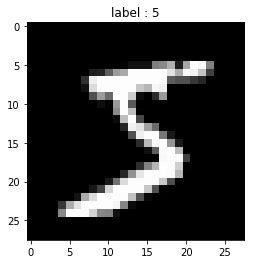

In [5]:
#### -- 2-2. MNIST 데이터 확인하기 -- ####
image, label = train_data[0]

plt.imshow(image.squeeze().numpy(), cmap = 'gray')
plt.title('label : %s' % label)
plt.show()

In [6]:
#### -- 2-3. Mini-Batch 구성하기 -- ####
train_loader = torch.utils.data.DataLoader(dataset = train_data, 
                                           batch_size = batch_size, shuffle = True)
test_loader  = torch.utils.data.DataLoader(dataset = test_data, 
                                           batch_size = batch_size, shuffle = True)

first_batch = train_loader.__iter__().__next__()
print('{:15s} | {:<25s} | {}'.format('name', 'type', 'size'))
print('{:15s} | {:<25s} | {}'.format('Num of Batch', '', len(train_loader)))
print('{:15s} | {:<25s} | {}'.format('first_batch', str(type(first_batch)), len(first_batch)))
print('{:15s} | {:<25s} | {}'.format('first_batch[0]', str(type(first_batch[0])), first_batch[0].shape))
print('{:15s} | {:<25s} | {}'.format('first_batch[1]', str(type(first_batch[1])), first_batch[1].shape))

name            | type                      | size
Num of Batch    |                           | 1200
first_batch     | <class 'list'>            | 2
first_batch[0]  | <class 'torch.Tensor'>    | torch.Size([50, 1, 28, 28])
first_batch[1]  | <class 'torch.Tensor'>    | torch.Size([50])


In [7]:
#### -- 3-1. CNN 구조 설계하기 -- ####
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [16]:
#### -- 3-2. Optimizer 및 손실함수 정의 -- ####
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss( )

In [17]:
#### -- 3-3. 설계한 CNN 모형 확인하기 -- ####
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [18]:
#### -- 3-4. 모델 학습하기 -- ###
model.train()
i = 1
for epoch in range(epoch_num):
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if i % 1000 == 0:
            print('Train Step: {}\tLoss: {:.3f}'.format(i, loss.item()))
        i += 1

Train Step: 1000	Loss: 0.194
Train Step: 2000	Loss: 0.165
Train Step: 3000	Loss: 0.034
Train Step: 4000	Loss: 0.076
Train Step: 5000	Loss: 0.049
Train Step: 6000	Loss: 0.114
Train Step: 7000	Loss: 0.010
Train Step: 8000	Loss: 0.081
Train Step: 9000	Loss: 0.021
Train Step: 10000	Loss: 0.034
Train Step: 11000	Loss: 0.018
Train Step: 12000	Loss: 0.028
Train Step: 13000	Loss: 0.058
Train Step: 14000	Loss: 0.097
Train Step: 15000	Loss: 0.012
Train Step: 16000	Loss: 0.127
Train Step: 17000	Loss: 0.059
Train Step: 18000	Loss: 0.053


In [20]:
#### -- 4. 모델 평가하기 -- ###
model.eval()
correct = 0
for data, target in test_loader:
#     data, target = Variable(data, volatile=True), Variable(target)
    data = data.to(device)
    target = target.to(device)
    output = model(data)
    prediction = output.data.max(1)[1]
    correct += prediction.eq(target.data).sum()

print('Test set: Accuracy: {:.2f}%'.format(100. * correct / len(test_loader.dataset)))

Test set: Accuracy: 99.00%


In [21]:
correct

tensor(9900, device='cuda:0')

In [22]:
prediction.eq(target.data)

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True], device='cuda:0')